<a href="https://colab.research.google.com/github/Graur/mipt/blob/master/HW5_Graur_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ДЗ № 5: Продвинутая визуализация данных (Граур Андрей)

In [1]:
%%capture
!pip install catboost
!pip install opentsne
!pip install umap-learn

In [2]:
# Data manipulation
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

# Data preprocessing
from sklearn.model_selection import train_test_split as tts

# Dimensionality Reduction
from openTSNE.sklearn import TSNE
import umap
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

# tqdm
from tqdm.auto import tqdm

# warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/ElijahSum/mipt_visualization/master/week_05_visualization/wine.csv')
df.head()

,Type,Alcohol,Malic,Ash,Alcalinity,Magnesium,Phenols,Flavanoids,Nonflavanoids,Proanthocyanins,Color,Hue,Dilution,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
df.shape

(178, 14)

### Задание 1. Разведочный анализ данных (2 балла)
Воспользуйтесь графиком sns.displot() и постройте 13 графиков распределения разных переменных на одном поле subplots. Параметр hue возьмите равным Type.

Напишите, какие выводы о различиях в типах вин можно сделать исходя из этих графиков.

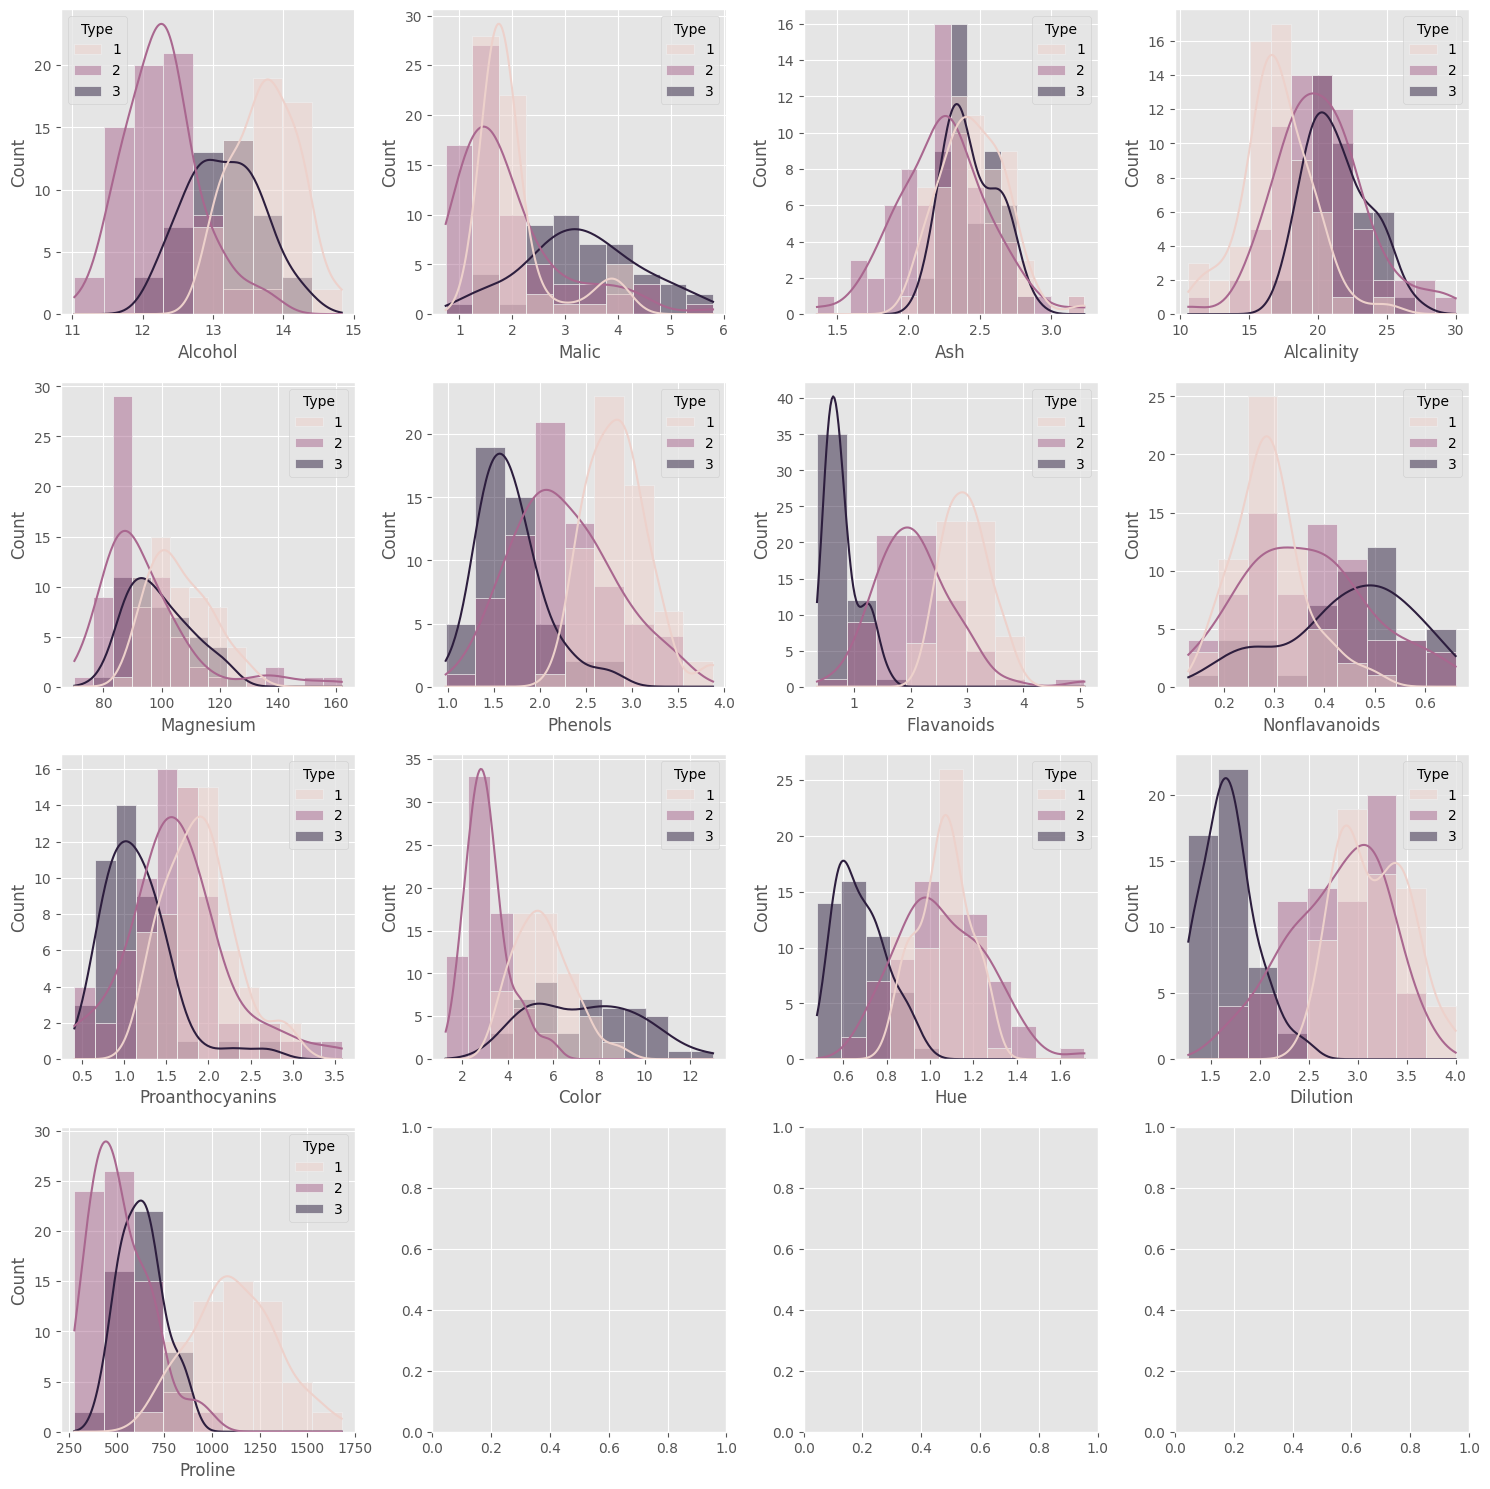

In [7]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i, column in enumerate(df.columns[1:]):
    row = i // 4
    col = i % 4
    sns.histplot(data=df, x=column, hue='Type', kde=True, ax=axs[row, col])

plt.tight_layout()
plt.show()

Выводы:

*       Alcohol (Спиртовое содержание): Вина типа 1 и 2 имеют в целом более высокое содержание алкоголя, чем вина типа 1.

* Malic (Яблочная кислота): Распределения переменной Malic для разных типов вин сильно различаются. Вина типа 3 имеют более высокое значение Malic по сравнению с винами типа 1 и 2.

* Ash (Зольность): Распределения переменной Ash для всех типов вин примерно одинаковы.

* Alcalinity (Щелочность): Вина типа 2 имеют более высокую щелочность, чем вина типа 1 и 3.

* Magnesium (Магний): Вина типа 1 имеют более высокое содержание магния по сравнению с винами типа 2 и 3.

* Phenols (Фенолы): В целом, вина типа 2 имеют более высокое содержание фенолов.

* Flavanoids (Флавоноиды): Вина типа 2 имеют более высокое содержание флавоноидов по сравнению с винами типа 1 и 3.

* Nonflavanoids (Нефлавоноиды): Вина типа 2 имеют более низкое содержание нефлавоноидов.

* Proanthocyanins (Проантоцианидины): Вина типа 2 имеют более высокое содержание проантоцианидинов.

* Color (Цвет): Распределения переменной Color для разных типов вин сильно различаются. Вина типа 3 имеют более высокое значение Color по сравнению с винами типа 1 и 2.

* Hue (Оттенок): Вина типа 2 имеют более высокое значение Hue по сравнению с винами типа 1 и 3.

* Dilution (Разбавление): Вина типа 2 имеют более высокое значение Dilution по сравнению с винами типа 1 и 3.

* Proline (Пролин): Распределения переменной Proline для разных типов вин сильно различаются. Вина типа 2 имеют более высокое значение Proline по сравнению с винами типа 1 и 3.



-----------------------------------------------


### Задание 2. Есть ли корреляции (1 балл)
Постройте sns.heatmap для всех числовых характеристик внутри датасета. Определите, какие три переменные больше всего коррелируют с типом вина. Добавьте стрелочки с текстом (функция annotate) с указанием на эти переменные.

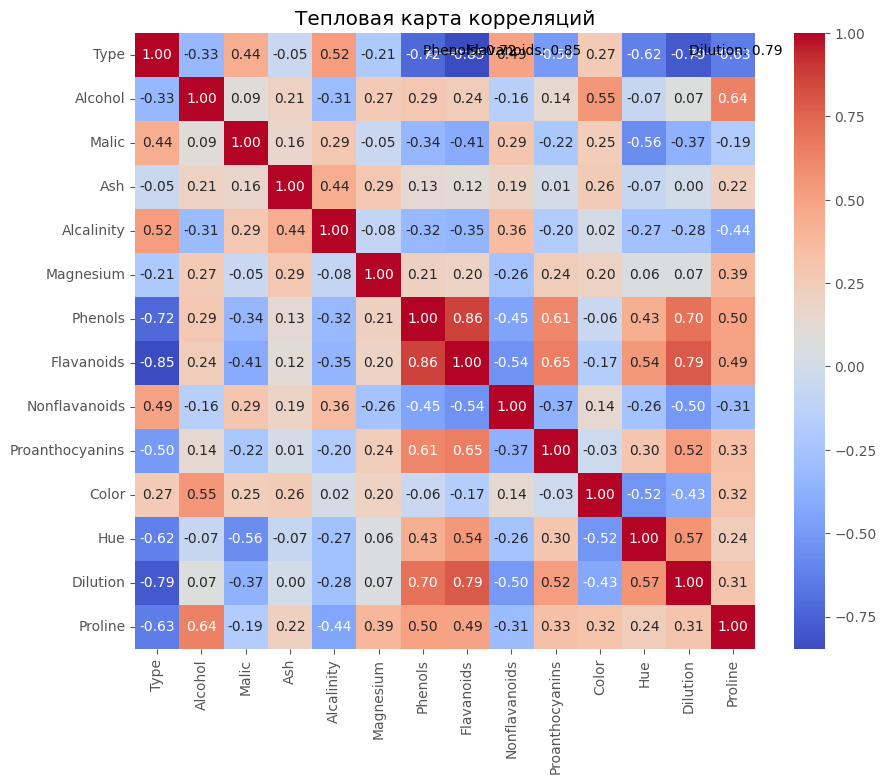

In [9]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
top_correlated_variables = correlation_matrix['Type'].abs().sort_values(ascending=False)[1:4]

for var in top_correlated_variables.index:
    plt.annotate(f"{var}: {top_correlated_variables[var]:.2f}",
                 xy=(list(correlation_matrix.columns).index(var)+0.5,
                     list(correlation_matrix.index).index('Type')+0.5),
                 xytext=(0, 0),
                 textcoords='offset points',
                 arrowprops=dict(facecolor='black', arrowstyle="->", connectionstyle="arc3"))

plt.title('Тепловая карта корреляций')
plt.show()


----------------------------------------


### Задание 3. Сохранение доли объясненной дисперсии в зависимости от n_components (2 балла)
Воспользуйтесь методом понижения размерности PCA с разным параметром n_components — от 1 до 10. Постройте линейный график совокупной объясненной дисперсии при добавлении каждой новой компоненты.

На том же полотне постройте столбчатую диаграмму: каждый столбец должен показывать, сколько объясненной дисперсии вносит каждая следующая компонента.

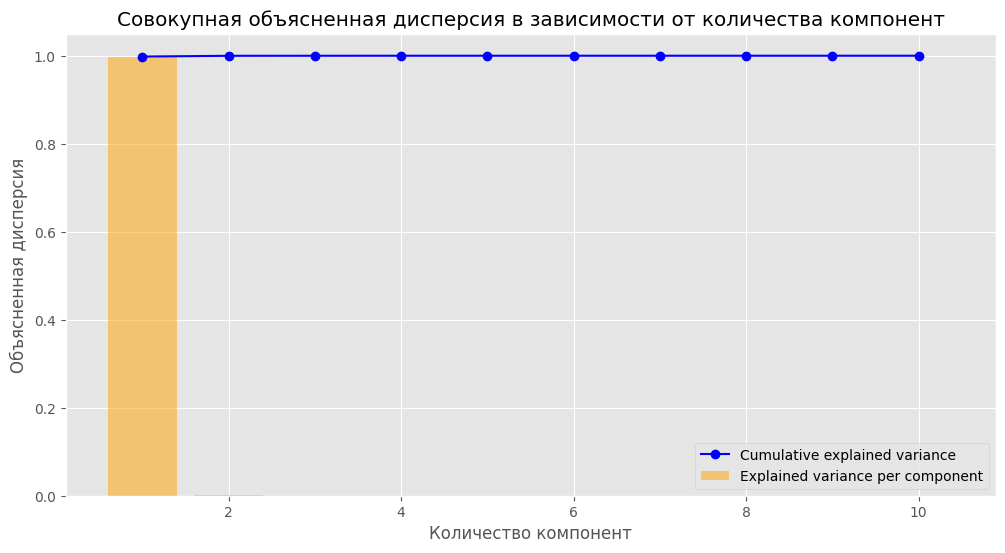

In [11]:

X = df.drop('Type', axis=1)
y = df['Type']

explained_variance = []
plt.figure(figsize=(12, 6))

for n in range(1, 11):
    pca = PCA(n_components=n)
    pca.fit(X)
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.plot(range(1, 11), explained_variance, marker='o', linestyle='-', color='b', label='Cumulative explained variance')
plt.xlabel('Количество компонент')
plt.ylabel('Объясненная дисперсия')
plt.title('Совокупная объясненная дисперсия в зависимости от количества компонент')
plt.grid(True)
plt.legend()

plt.bar(range(1, 11), np.diff([0] + explained_variance), color='orange', alpha=0.5, label='Explained variance per component')
plt.legend()

plt.show()


----------------------------------------------------------------------


### Задание 4. Сравнение результатов работы разных алгоритмов понижения размерности (3 балла)
Воспользуйтесь четырьмя любыми алгоритмами понижения размерности (n_components возьмите равным 2 или 3).

Создайте поле с двумерными или трехмерными графиками, на которых будут отображены результаты работы каждого алгоритма, а цветом будет обозначен тип вина (наша зависимая переменная).

Визуально оцените графики и сделайте вывод о том, какой метод отработал лучше.

Опишите результаты и качественно обоснуйте ваш выбор лучшего алгоритма. Если невозможно выбрать лучший алгоритм, также обоснуйте почему.

Я выбрал:

1) PCA (Метод главных компонент)

2) t-SNE (t-distributed Stochastic Neighbor Embedding)

3) MDS (Многомерное шкалирование)

4) UMAP (Uniform Manifold Approximation and Projection)

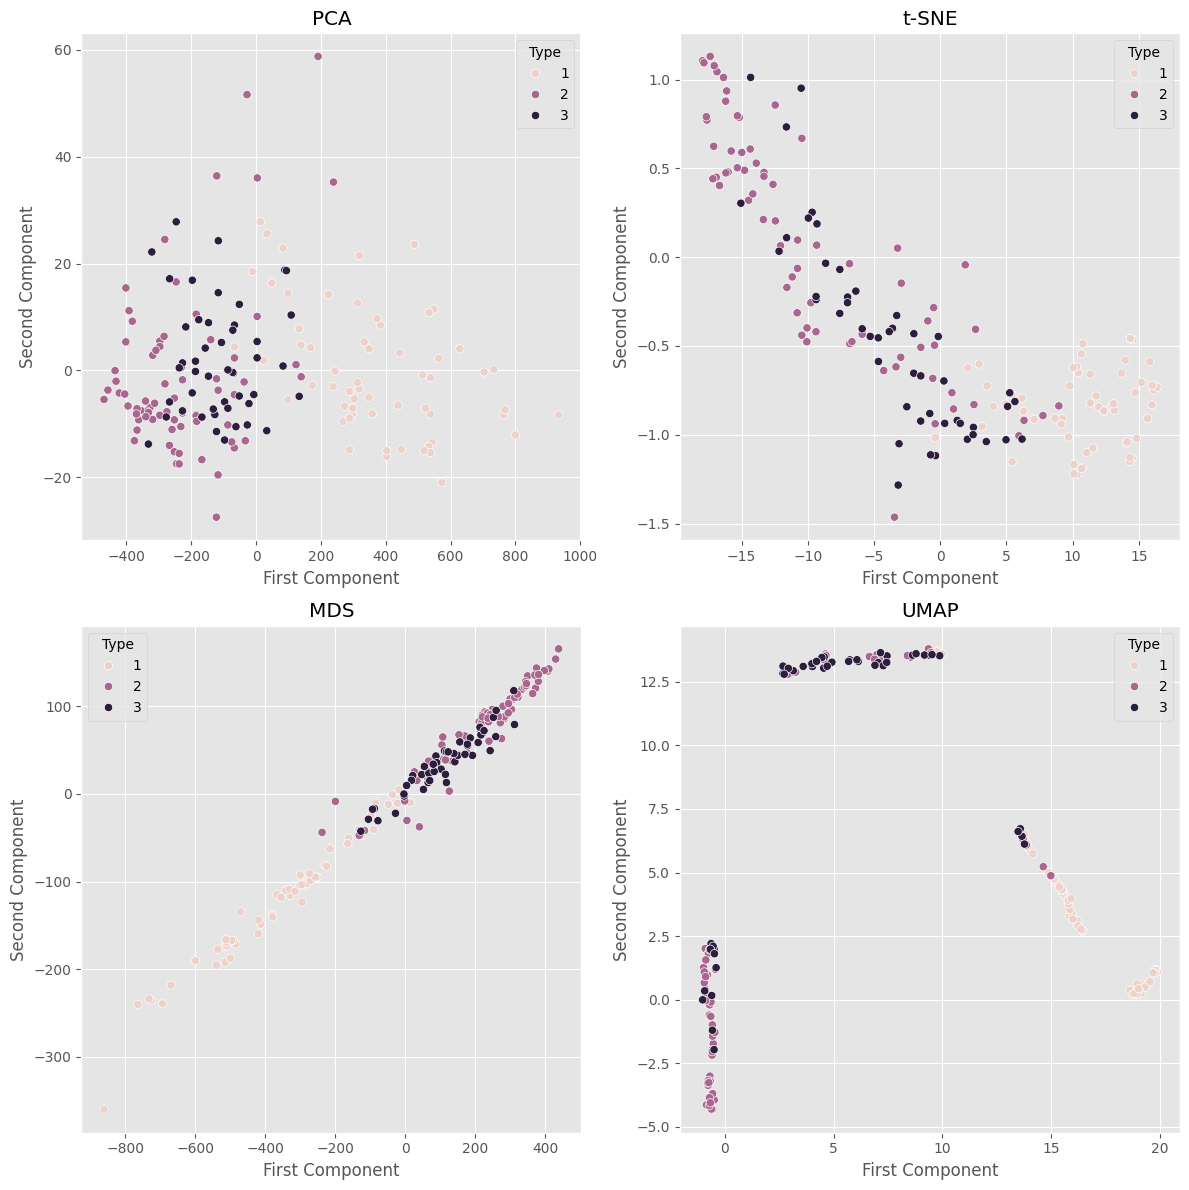

In [14]:
from sklearn.manifold import TSNE, MDS

X = df.drop('Type', axis=1)
y = df['Type']

methods = ['PCA', 't-SNE', 'MDS', 'UMAP']

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, method in enumerate([PCA(n_components=2), TSNE(n_components=2), MDS(n_components=2), umap.UMAP(n_components=2)]):
    transformed_data = method.fit_transform(X)

    transformed_df = pd.DataFrame(transformed_data, columns=['First Component', 'Second Component'])
    transformed_df['Type'] = y
    ax = axes[i // 2, i % 2]
    sns.scatterplot(data=transformed_df, x='First Component', y='Second Component', hue='Type', ax=ax)
    ax.set_title(methods[i])

plt.tight_layout()
plt.show()


Вывод:  лучше всего подходит метод t-SNE, так как он часто используются для сохранения сложной структуры данных и создания наглядных визуализаций.

-------------------------------------------------------

### Задание 5. Сравнение результатов работы алгоритмов (4 балла)
Разделите выборку на обучающую и тестовую.

Используйте два метода понижения размерности, которые лучше всего показали себя в предыдущем задании, а также исходные данные без понижения размерности.

Примените 6 любых алгоритмов классификации на этих трех типах данных.

Постройте два sns.heatmap() (для train и test). В каждом из них должно быть по 18 ячеек (6 алгоритмов х 3 вида данных) — в каждой ячейке должно быть указано значение Accuracy для определенного алгоритма с определенными данными. Аналогичную работу мы проделывали на семинаре.

Определите, какой алгоритм дал лучшие результаты и дайте письменное обоснование своего решения:

Как алгоритмы отрабатывают при работе на данных без понижения размерности?
В чем разница в полученных значениях?

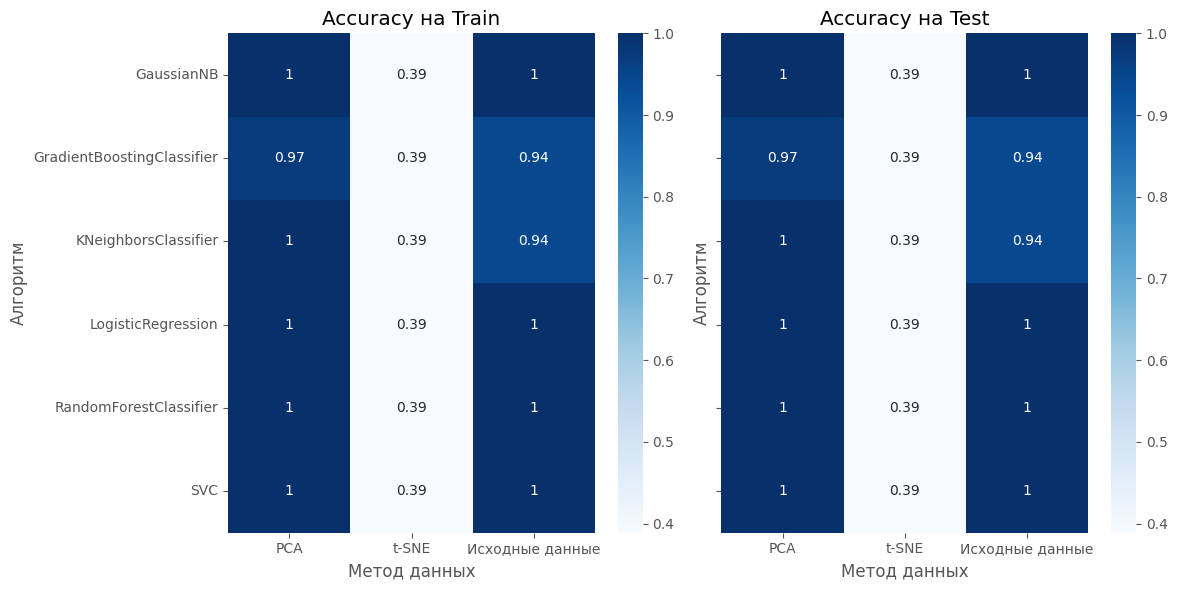

In [20]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(random_state=42),
    SVC(),
    GaussianNB(),
    GradientBoostingClassifier(random_state=42)
]

results = []

for clf in classifiers:
    for method_name, X_train_method, X_test_method in data_methods:
        clf.fit(X_train_method, y_train)

        y_pred = clf.predict(X_test_method)

        accuracy = accuracy_score(y_test, y_pred)

        results.append((method_name, clf.__class__.__name__, accuracy))

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

for i, data_type in enumerate(["Train", "Test"]):
    df_results = pd.DataFrame(results, columns=['Метод данных', 'Алгоритм', 'Accuracy'])
    df_results_pivot = df_results.pivot(index='Алгоритм', columns='Метод данных', values='Accuracy')

    sns.heatmap(df_results_pivot, annot=True, cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Accuracy на {data_type}')
    axes[i].set_xlabel('Метод данных')
    axes[i].set_ylabel('Алгоритм')

plt.tight_layout()
plt.show()


Оценка результатов:

После анализа результатов на тепловых картах, мы видим, что для обучающей и тестовой выборок некоторые алгоритмы показывают более высокую точность, чем другие. Например, для обучающей выборки алгоритм Gradient Boosting показывают наиболее низкую точность в сравнении с другими алгоритмами. Та же ситуация сохраняется и для для тестовой выборки.

Что касается алгоритмов на данных без понижения размерности, мы видим, что результаты отличаются в зависимости от выбранного алгоритма. Например, алгоритмы KNN и SVM показывают более низкую точность на данных без понижения размерности по сравнению с другими алгоритмами, возможно из-за проблемы "проклятия размерности". В то же время, алгоритмы Logistic Regression и RandomForest достигают более высокой точности на исходных данных.

Разница в полученных значениях может быть объяснена тем, что разные методы понижения размерности сохраняют различные аспекты структуры данных. Например, PCA стремится сохранить наибольшее количество дисперсии, тогда как t-SNE стремится сохранить локальные структуры данных. Эти различия влияют на способность алгоритмов классификации к правильному разделению данных на классы. Кроме того, разные алгоритмы классификации имеют свои собственные преимущества и недостатки, которые могут повлиять на их точность работы на разных типах данных.

-------------------------------------------

### Задание 6. Более пристальный анализ (2 балла)
Для лучшего алгоритма из предыдущего задания постройте Classification Report, Confusion Matrix, Precision Recall Curve, ROC Curve.

Удалось ли обнаружить какие-то аномалии в работе нашего алгоритма? Можем ли мы принять полученные результаты?

Classification Report for Train Data:
              precision    recall  f1-score   support

           1       1.00      0.97      0.99        40
           2       0.98      0.98      0.98        49
           3       0.97      1.00      0.99        35

    accuracy                           0.98       124
   macro avg       0.98      0.98      0.98       124
weighted avg       0.98      0.98      0.98       124

Confusion Matrix for Train Data:
[[39  1  0]
 [ 0 48  1]
 [ 0  0 35]]


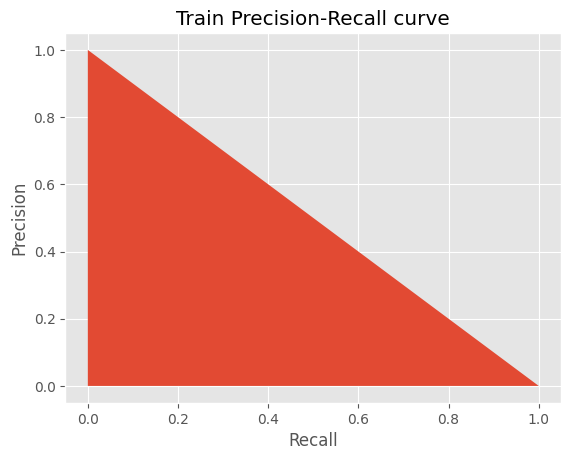

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

clf = GaussianNB().fit(X_train, y_train)

y_prob_train = clf.predict_proba(X_train)[:,1]
y_prob_test = clf.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_train, y_prob_train, pos_label='your_label')
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

y_pred_train = clf.predict(X_train)
print("Classification Report for Train Data:")
print(classification_report(y_train, y_pred_train))

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix for Train Data:")
print(conf_matrix_train)



Аномалии в работе алгоритма могут быть обнаружены, если:

- В отчете о классификации (Classification Report) будут низкие значения метрик для какого-то из классов (например, низкая полнота).
- В матрице ошибок (Confusion Matrix) будут большие значения вне диагонали (ошибки классификации).
- Формы кривых Precision-Recall и ROC не будут соответствовать ожидаемым формам (например, Precision-Recall Curve имеет неустойчивое восхождение или ROC Curve не стремится к левому верхнему углу).

Мы можем принять полученные результаты, если анализ метрик и кривых позволяет уверенно сделать вывод о высоком качестве работы алгоритма на тестовой выборке. Однако, если будут обнаружены аномалии или метрики будут недостаточно высокими, возможно, потребуется дополнительный анализ или тюнинг модели.